In [67]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision import models
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [68]:
def apply_clahe(img, **kwargs):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    
    return cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)

In [69]:
def get_transforms():
    return A.Compose([
        A.Lambda(image=apply_clahe),
        A.Resize(512, 512),
        A.Normalize(mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

In [70]:
class GlaucomaDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.df.loc[idx, 'image_path'])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.df.loc[idx, 'label']

        if self.transform:
            image = self.transform(image=image)['image']

        return image, label, img_path

In [87]:
def generate_gradcam(model, input_tensor, target_class, device, model_name):
    model.eval()
    input_tensor = input_tensor.unsqueeze(0).to(device)

    gradients = []
    activations = []

    if model_name == 'resnet50':
        target_layer = model.layer4[2].conv3
    elif model_name == 'efficientnet_b0':
        target_layer = model.features[-1][0]
    elif model_name == 'densenet121':
        target_layer = model.features.denseblock4.denselayer16.conv2
    else:
        print(f"Grad-CAM not supported for {model_name}")
        return None

    def forward_hook(module, input, output):
        activations.append(output.clone())

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0].clone())

    fw = target_layer.register_forward_hook(forward_hook)
    bw = target_layer.register_full_backward_hook(backward_hook)

    output = model(input_tensor)
    loss = output[0, target_class]
    model.zero_grad()
    loss.backward()

    fw.remove()
    bw.remove()

    grads = gradients[0].squeeze().detach().cpu().numpy()
    acts = activations[0].squeeze().detach().cpu().numpy()

    weights = grads.mean(axis=(1, 2))
    cam = np.zeros(acts.shape[1:], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * acts[i, :, :]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (input_tensor.size(3), input_tensor.size(2)))
    cam = (cam - cam.min()) / (cam.max() + 1e-8)

    return cam

In [88]:
def show_gradcam_on_image(img_tensor, cam, title="Grad-CAM"):
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    overlay = heatmap + img
    overlay = overlay / np.max(overlay)
    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.axis('off')
    plt.title(title)
    plt.show()

In [89]:
def load_model(model_name, model_path, device):
    if model_name == 'resnet50':
        model = models.resnet50(weights=None)
        model.fc = torch.nn.Linear(model.fc.in_features, 2)
    elif model_name == 'efficientnet_b0':
        model = models.efficientnet_b0(weights=None)
        model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 2)
    elif model_name == 'densenet121':
        model = models.densenet121(weights=None)
        model.classifier = torch.nn.Linear(model.classifier.in_features, 2)
    else:
        raise ValueError(f"Unsupported model: {model_name}")

    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    
    return model

In [90]:
def explain_random_image(model, dataset, device, model_name):
    import random
    idx = random.randint(0, len(dataset) - 1)
    img_tensor, label, img_path = dataset[idx]
    input_tensor = img_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        pred = output.argmax(dim=1).item()

    print(f"\nModel: {model_name}")
    print(f"Image: {img_path}")
    print(f"Ground Truth: {label}, Predicted: {pred}")

    cam = generate_gradcam(model, img_tensor, pred, device, model_name)
    if cam is not None:
        show_gradcam_on_image(img_tensor, cam, title=f"{model_name} Grad-CAM")

In [91]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [92]:
labels_csv_path = "/kaggle/input/unified-dataset/labels.csv"
labels_df = pd.read_csv(labels_csv_path)
val_dataset = GlaucomaDataset(labels_df, root_dir="/kaggle/input/unified-dataset", transform=get_transforms())

In [93]:
models_info = {
    "resnet50": "/kaggle/input/resnet/pytorch/default/1/resnet50_best.pth",
    "efficientnet_b0": "/kaggle/input/efficientnet/pytorch/default/1/efficientnet_b0_best.pth",
    "densenet121": "/kaggle/input/densenet/pytorch/default/1/densenet121_best.pth"
}


Model: resnet50
Image: /kaggle/input/unified-dataset/images/EYEPACS_EyePACS-DEV-RG-840.jpg
Ground Truth: 1, Predicted: 1


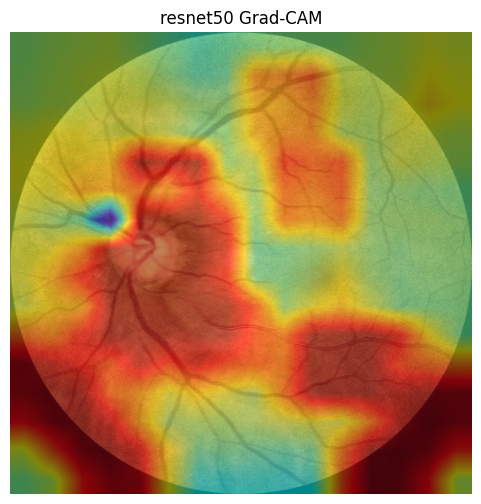


Model: efficientnet_b0
Image: /kaggle/input/unified-dataset/images/EYEPACS_EyePACS-DEV-NRG-1012.jpg
Ground Truth: 0, Predicted: 0


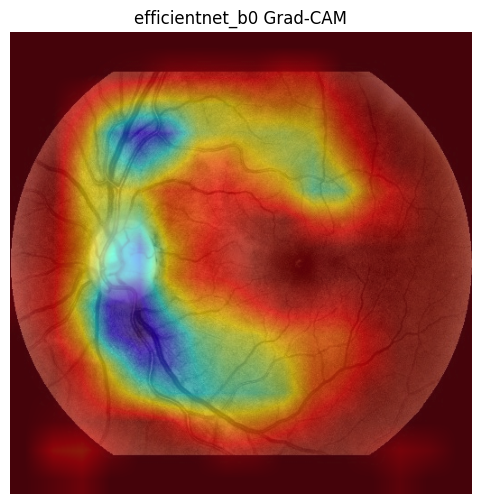


Model: densenet121
Image: /kaggle/input/unified-dataset/images/EYEPACS_EyePACS-DEV-RG-1026.jpg
Ground Truth: 1, Predicted: 1


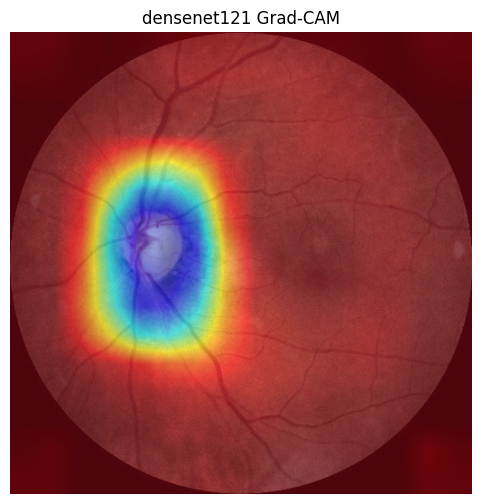

In [94]:
for model_name, model_path in models_info.items():
    model = load_model(model_name, model_path, device)
    explain_random_image(model, val_dataset, device, model_name)